In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')


from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Loading Data 

In [2]:
os.chdir('..')

In [3]:
data = pd.read_parquet(os.path.join(os.getcwd(), 'data','modelData', 'modelData.parquet'))

In [4]:
data = data.query("MASK == 2 & BIN == 32")\
           .reset_index(drop = True)

# Splitting data 

In [5]:
y = data[["SEVERE"]]
X = data.drop(columns = ["MASK", "BIN", "SEVERE", "ID"])
cols = X.columns

# Processing Data

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns  = cols)

# Settings Regression

In [7]:
logreg = LogisticRegression(penalty = "l1",
                            C = 0.3, # Smaller values specify stronger regularization.
                            solver = "saga",
                            max_iter = 10000,
                            n_jobs = 1)
sfs  = SFS(logreg, 
           k_features=5, 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='roc_auc',
           cv=4,
           n_jobs=-1)


# Feature Selection 

In [8]:
sfs = sfs.fit(X, y.values.squeeze())

In [9]:
result = sfs.get_metric_dict(confidence_interval=0.95)
aux=pd.DataFrame.from_dict(result).T

# Final Model

In [10]:
X_feat = X.filter(['Energy_FO',
                   'Coarseness_NGTDM'])

In [11]:
logreg = LogisticRegressionCV(cv = 4,
                              scoring='roc_auc',
                              solver = 'saga',
                              penalty = 'l1',
                              Cs = [0.3],
                              max_iter= 10000,
                              n_jobs = -1,
                              ).fit(X_feat, y["SEVERE"].values)

In [22]:
logreg.coef_.T.shape

(2, 1)

In [20]:
np.dot(X_feat, logreg.coef_.T)

array([[-1.75235995],
       [-0.81006149],
       [-0.92773124],
       [-1.63751117],
       [-1.6680954 ],
       [-0.35664413],
       [-1.92282308],
       [ 1.90304929],
       [-1.76443335],
       [ 1.25469888],
       [-1.75851192],
       [ 0.82221312],
       [-1.29977526],
       [-1.47096236],
       [-1.39259573],
       [-0.73956153],
       [-1.71208396],
       [-0.15470521],
       [-0.90016083],
       [-0.06704493],
       [-1.38986979],
       [-1.02153231],
       [ 2.00556209],
       [-0.73932127],
       [-0.11298945],
       [-0.50476442],
       [ 1.33989664],
       [-1.78573516],
       [-0.86634207],
       [ 1.71460432],
       [ 0.96744486],
       [ 1.86405832],
       [-0.07006341],
       [ 1.38474273],
       [-1.69274797],
       [-1.73135069],
       [ 1.78885624],
       [-1.13711341],
       [ 2.58143448],
       [-0.42755081],
       [-0.69911912],
       [-0.5431046 ],
       [ 1.56988154],
       [ 0.14631067],
       [ 1.44631833],
       [-0

In [14]:
assinatura = pd.Series((X_feat.dot(logreg.coef_.T)).squeeze())
label=pd.Series(np.where(y["SEVERE"].values == 0, 'blue','red'))
assinaturaLabel = pd.concat([assinatura, label], axis = 1, names=['label'])
assinaturaLabel.columns = ['ASSINATURA','SEVERE']
assinaturaLabel.sort_values(by='ASSINATURA', inplace = True)
label=assinaturaLabel['SEVERE'].to_list()

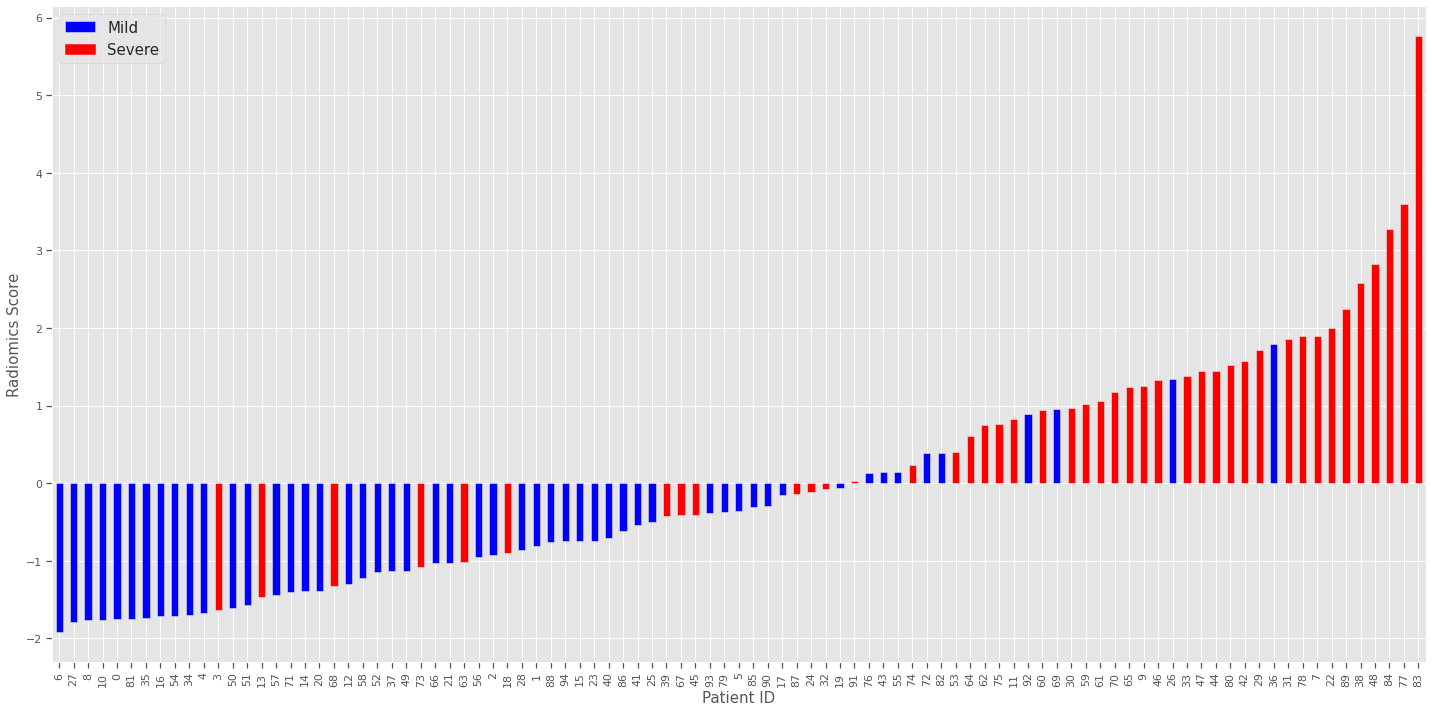

In [15]:
ax=assinaturaLabel['ASSINATURA'].plot(kind = 'bar', color = label, figsize = (20,10))
plt.ylabel("Radiomics Score",fontsize = 15)
plt.xlabel("Patient ID",fontsize = 15)
plt.legend(['0','1'])
# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch(color='red', label='Severe')

# handles is a list, so append manual patch
handles.append(patch) 
labels = 'Mild'
L=plt.legend(handles=handles, loc='upper left',fontsize = 15)
L.get_texts()[0].set_text('Mild')
plt.tight_layout()
plt.savefig(os.path.join("figures", "model", "signature.png"),format= 'png', bbox_inches='tight')
plt.show()

In [16]:
logreg.scores_[1].mean(axis = 1).mean()

0.8615384615384616

In [17]:
logreg.scores_[1].mean(axis = 1).std()

0.03427286924431567